In [188]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [189]:
%config Completer.use_jedi=False
import yaml
import torch
import numpy as np
from pathlib import Path
import torchvision as tv
from ipywidgets import interact
import matplotlib.pyplot as plt
import torch.nn.functional as F

import pytorch_tools as pt
from pytorch_tools.utils.misc import count_parameters

from src.dali_dataloader import DaliLoader, ValRectExternalInputIterator, ValRectPipe, ValRectLoader
from src.angular_losses import SphereLinearLayer

# Evaluate

In [190]:
INP = torch.ones(2, 3, 224, 224).cuda()
PRED = torch.ones(2, 1000).cuda()
LOSS = pt.losses.CrossEntropyLoss().cuda()
METRIC = [pt.metrics.Accuracy(), pt.metrics.Accuracy(5)]
class Foo: # used to stack and then inspect all predictions
    def __init__(self):
        self.name = "Foo"
    def __call__(self, *args, **kwargs):
        return torch.tensor(0)
    
@torch.no_grad()
def evaluate_model(model, size=224, rect=False, **kwargs):
    """Eval model on ImageNet validation dataset"""
    BS = 25 if size >= 384 else 125
    if rect:
        val_loader = ValRectLoader(bs=BS, workers=12, **kwargs)
    else:
        val_loader = DaliLoader(False, bs=BS, sz=size, workers=12, **kwargs)
    model = model.eval().cuda()
    runner = pt.fit_wrapper.Runner(
        model,
        None,
        LOSS,
        callbacks=[
            pt.fit_wrapper.callbacks.BatchMetrics(METRIC),
            pt.fit_wrapper.callbacks.LoaderMetrics(Foo()),
        ],
        use_fp16=True,
    )
    runner.callbacks.on_begin()
    _, (acc1, acc5, foo) = runner.evaluate(val_loader)
    print(f"Acc@1: {acc1:.2f}. Acc@5: {acc5:.2f}")
    return acc1, acc5, runner

In [17]:
# PATH = "logs/exp48.GENet_no_dim_red_ctmx_20201031_180205/"
# PATH = "logs/exp90.BNet_asoft_ctmx_20201109_095536/"
# PATH = "logs/exp90.BNet_asoft_ctmx_64_20201110_210928/"
PATH = "logs/exp90.BNet_asoft_ctmx_128_20201110_082241/"
# PATH = "logs/exp92.BNet_arcsoft_20201109_194344/"
# PATH = "logs/exp92.BNet_arcsoft_64_20201110_211920/"


# PATH = "/home/zakirov/exp55.GENet_no_dim_red_ctmx_ws_20201006_182419/"
# PATH = "/home/zakirov/repoz/sota_imagenet/logs/exp56.GENet_no_dim_red_ctmx_ws_adam_20201007_072753/"
PATH = Path(PATH)
model_config = yaml.load(open(PATH / "config.yaml"))
model_config["model_params"].pop("mobilenetv3_head", None)
model_config["model_params"]["head_type"] = "default"
model = pt.models.BNet(**model_config["model_params"])
model = model.eval().requires_grad_(False).cuda()
# model = pt.modules.conv_to_ws_conv(model)
model.last_linear.weight.shape

torch.Size([1000, 128])

In [18]:
sd = torch.load(PATH / "model.chpn")["state_dict"]
model.load_state_dict(sd, strict=False)

_IncompatibleKeys(missing_keys=['last_linear.bias'], unexpected_keys=[])

In [19]:
sphere_linear = SphereLinearLayer(model.last_linear.weight.size(1), model.last_linear.weight.size(0)).requires_grad_(False)
sphere_linear.load_state_dict(model.last_linear.state_dict(), strict=False)
model.last_linear = sphere_linear

In [20]:
# R-50 GN + WS Acc@1: 76.33. Acc@5: 93.34 
# X-50-GN-WS Acc@1: 77.28. Acc@5: 93.61
# R-101 GN + WS Acc@1: 77.85. Acc@5: 93.90
# X-101-GN-WS Acc@1: 78.19. Acc@5: 93.98

In [21]:
if (Path("val_features") / f"{PATH.name}_pred").exists():
    all_output = torch.load(f"val_features/{Path(PATH).name}_pred")
    all_target = torch.load(f"val_features/{Path(PATH).name}_true")
else:
    # calculate features and save them
    _, _, runn = evaluate_model(model, rect=True, resize_method="triang")
    all_target = torch.cat(runn.callbacks.callbacks[1].target).float()
    all_output = torch.cat(runn.callbacks.callbacks[1].output, dim=0).float()
    torch.save(all_output, f"val_features/{Path(PATH).name}_pred")
    torch.save(all_target, f"val_features/{Path(PATH).name}_true")

correct = all_output.argmax(dim=1).eq(all_target)
print(f"{correct.float().mean() * 100:.2f}")

# get embeddings by inverse of last weight matrix
class_inverse = torch.pinverse(F.normalize(model.last_linear.weight))
all_embeddings = all_output @ class_inverse.T

77.04


In [46]:
batch_cos = all_output[:1000]
batch_true = all_target[:1000]

In [220]:
class_vectors = F.normalize(model.last_linear.weight)

In [221]:
class_cos = (class_vectors @ class_vectors.T)
class_cos_flat = torch.triu(class_cos, diagonal=1).flatten()
class_cos_flat = class_cos_flat[class_cos_flat != 0].sort()[0].cpu()

In [222]:
most_sim_val, mos_sim_index = torch.triu(class_cos, diagonal=1).max(-1)[0].topk(14)
most_sim_val, mos_sim_index

(tensor([0.9854, 0.9651, 0.9638, 0.9598, 0.9561, 0.9534, 0.9513, 0.9490, 0.9435,
         0.9418, 0.9379, 0.9312, 0.9229, 0.9187]),
 tensor([657, 435, 836, 248,  66, 461, 638, 265, 482,  40, 620, 987, 810,  82]))

In [365]:
def lunif(x, t=2):
    sq_pdist = torch.pdist(x, p=2).pow(2)
    return sq_pdist.mul(-t).exp().mean().log()
lunif(F.normalize(model.last_linear.weight).T)
# lunif(torch.randn(1000, 128))

tensor(-13.9534)

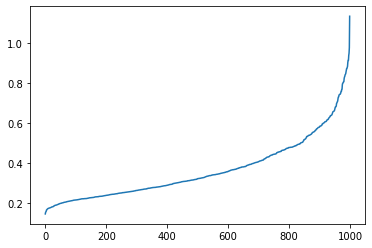

0.36483899043500423

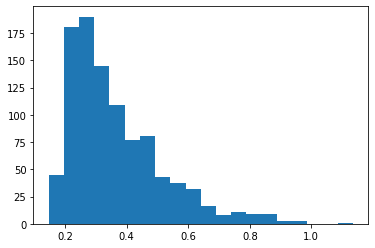

In [192]:
# asoft 64
all_cls_med = []
for cls in range(1000):
    cls_med = torch.acos(all_embeddings[all_target.eq(cls)] @ class_vectors[cls]).median()
    all_cls_med.append(cls_med.item())
plt.plot(sorted(all_cls_med));
plt.show()
plt.hist(all_cls_med, bins=20);
np.mean(all_cls_med)

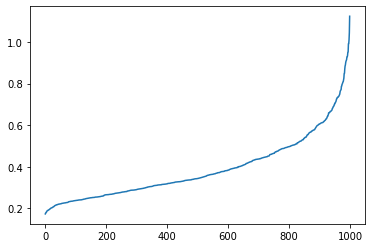

0.3897111783623695

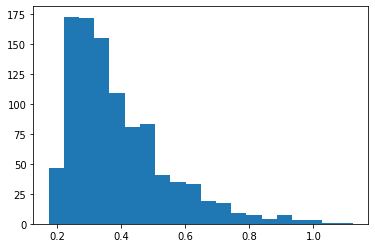

In [181]:
# asoft 128
all_cls_med = []
for cls in range(1000):
    cls_med = torch.acos(all_embeddings[all_target.eq(cls)] @ class_vectors[cls]).median()
    all_cls_med.append(cls_med.item())
plt.plot(sorted(all_cls_med));
plt.show()
plt.hist(all_cls_med, bins=20);
np.mean(all_cls_med)

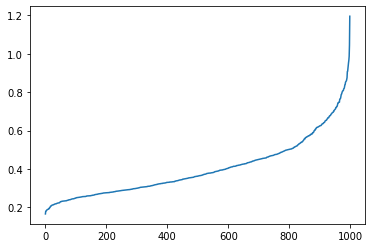

0.4014035161435604

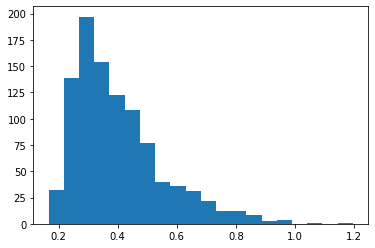

In [170]:
# asoft 256
all_cls_med = []
for cls in range(1000):
    cls_med = torch.acos(all_embeddings[all_target.eq(cls)] @ class_vectors[cls]).median()
    all_cls_med.append(cls_med.item())
plt.plot(sorted(all_cls_med));
plt.show()
plt.hist(all_cls_med, bins=20);
np.mean(all_cls_med)

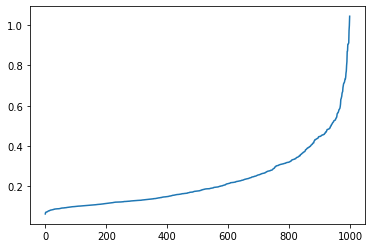

0.2297485058903694

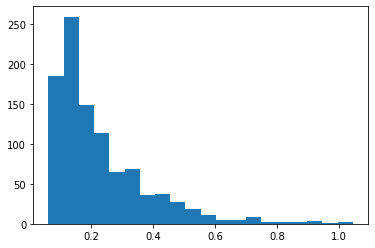

In [150]:
# arcsoft 64
all_cls_med = []
for cls in range(1000):
    cls_med = torch.acos(all_embeddings[all_target.eq(cls)] @ class_vectors[cls]).median()
    all_cls_med.append(cls_med.item())
plt.plot(sorted(all_cls_med));
plt.show()
plt.hist(all_cls_med, bins=20);
np.mean(all_cls_med)

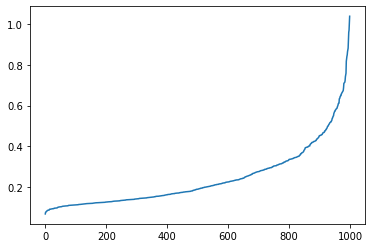

0.24316023714840412

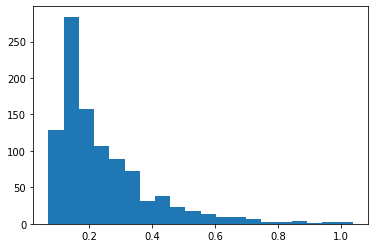

In [160]:
# arcsoft 256
all_cls_med = []
for cls in range(1000):
    cls_med = torch.acos(all_embeddings[all_target.eq(cls)] @ class_vectors[cls]).median()
    all_cls_med.append(cls_med.item())
plt.plot(sorted(all_cls_med));
plt.show()
plt.hist(all_cls_med, bins=20);
np.mean(all_cls_med)

In [310]:
all_output[8].mul(15).softmax(-1).max()

tensor(0.9202)

In [311]:
oo.mul(15).softmax(-1).max()

tensor(1.)

In [317]:
oo = torch.acos(all_output[8]).neg().mul(15)
oo.softmax(-1).max()

tensor(0.9945)

In [282]:
B = (oo - oo.max()).exp().sum() - 1
B

tensor(0.4266)

In [283]:
B.log(), (1 / B).log()

(tensor(-0.8520), tensor(0.8520))

In [297]:
all_target[N].long()

tensor(594)

In [338]:
N = 11
torch.acos(all_output[N]).mean() / np.pi * 2

tensor(0.9992)

In [318]:
N = 7
(torch.acos(all_output[N]) - torch.acos(all_output[N])[all_target[N].long()]).mean()

tensor(1.4760)

In [355]:
s = 10
m = 0.1
t_theta = 0.1
C = 1000
np.e ** (- s * (t_theta + m)) / (np.e ** (- s * (t_theta + m)) + np.e ** (- s * np.pi / 2) * (C-1))

0.998888806149875

In [ ]:
p_max = 0.98 
B = 0.002
B.log() = - 6.15

p_max = 0.7
B = 0.42
B.log() = -0.85

In [255]:
B = (oo - oo.max()).exp().sum() - 1
B

tensor(0.0055)

In [254]:
B.log(), (1 / B).log()

(tensor(-5.2066), tensor(5.2066))

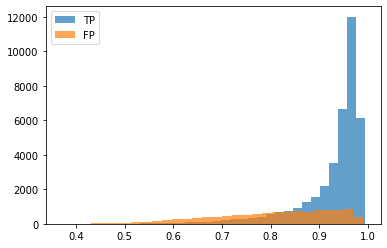

In [32]:
# pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = all_output.max(-1)[0]
# pos_cos = torch.acos(pos_cos)
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

In [124]:
torch.Tensor.scatter_add_?

In [133]:
all_output[0, all_target[0].long()]

tensor(0.3989)

In [137]:
1 + torch.tensor(10)

tensor(11)

In [187]:
cos = np.random.rand(100)
np.median(cos) - np.cos(np.median(np.arccos(cos)))

-7.6023243250622485e-06

In [158]:
np.log(1512602)

14.229341904629822

In [139]:
all_output.scatter_add(dim=1, index=all_target.long()[..., None], src=torch.tensor(-10.0).expand(50000, 1))

tensor([[-0.1150, -0.0387, -0.0559,  ..., -0.1390, -0.0066,  0.0260],
        [ 0.0428,  0.0336, -0.0380,  ..., -0.1256, -0.0080, -0.1426],
        [ 0.1290,  0.0086,  0.0053,  ...,  0.0461, -0.0276, -0.0336],
        ...,
        [-0.0177, -0.0170, -0.0471,  ..., -0.2334,  0.0470,  0.0412],
        [ 0.0837, -0.0144, -0.1389,  ..., -0.0506, -0.0293,  0.0453],
        [ 0.0077, -0.0851, -0.0515,  ..., -0.1360, -0.0324,  0.0383]])

In [111]:
all_output.argmax(-1)

tensor([473, 635, 797,  ..., 807, 764, 683])

In [88]:
m = 0.35
np.log(382433.9062) / (0.9 - m)

23.371474769217663

In [67]:
s = 16
oo = all_output.scatter(dim=1, index=all_target.long()[..., None], value=-1)
oo.mul(16).exp().sum(-1).mean()

tensor(382433.9062)

In [107]:
m = 0.2
np.log(np.e ** (s * (1 - m)) + 3e5) / s

0.8377093284197789

In [62]:
((all_output).mul(16).exp().sum(-1)).mean()

tensor(3446204.)

In [48]:
((all_output - all_output.max(-1)[0][..., None]).mul(16).exp().sum(-1) - 1).mean()

tensor(0.2064)

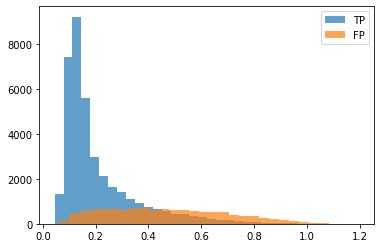

In [52]:
# pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = all_output.max(-1)[0]
pos_cos = torch.acos(pos_cos)
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

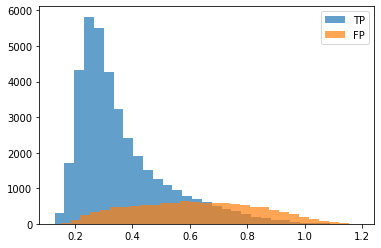

In [41]:
# pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = all_output.max(-1)[0]
pos_cos = torch.acos(pos_cos)
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

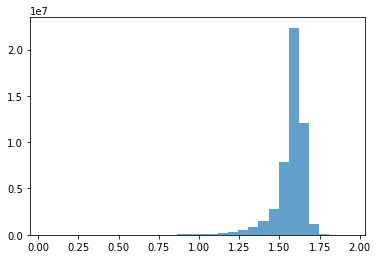

In [85]:
pos_cos = all_output.sort(-1, descending=True)[0][5:]
pos_cos = torch.acos(pos_cos)
plt.hist(pos_cos.flatten().cpu(), bins=30, alpha=0.7);

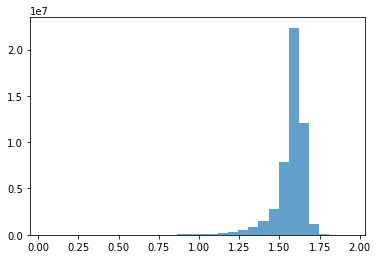

In [86]:
pos_cos = all_output.sort(-1, descending=True)[0][5:]
pos_cos = torch.acos(pos_cos)
plt.hist(pos_cos.flatten().cpu(), bins=30, alpha=0.7);

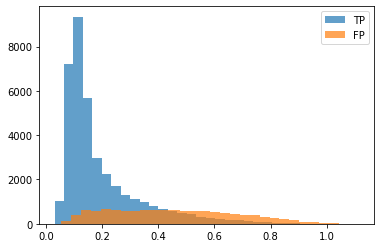

In [177]:
# pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = all_output.max(-1)[0]
pos_cos = torch.acos(pos_cos)
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

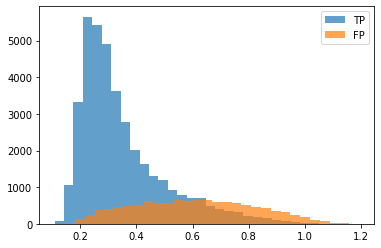

In [171]:
# pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = all_output.max(-1)[0]
pos_cos = torch.acos(pos_cos)
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

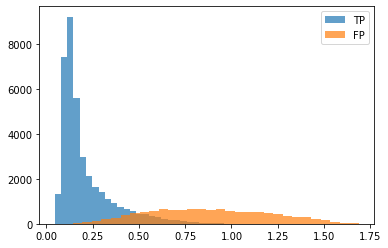

In [140]:
pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = torch.acos(pos_cos.float())
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

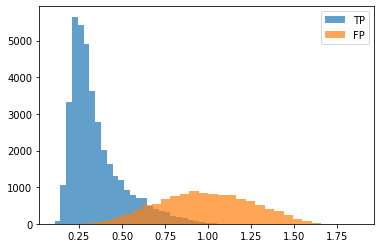

In [133]:
pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = torch.acos(pos_cos.float())
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

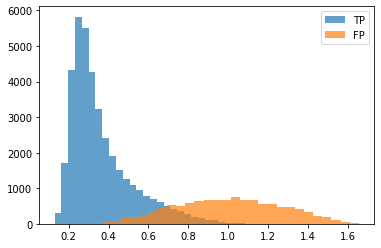

In [126]:
pos_cos = all_output.gather(-1, index=all_target[..., None])
pos_cos = torch.acos(pos_cos.float())
corr_pos_cos = pos_cos[correct]
incorr_pos_cos = pos_cos[~correct]
plt.hist(corr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.hist(incorr_pos_cos.flatten().cpu(), bins=30, alpha=0.7);
plt.legend(["TP", "FP"]);

Text(0.5, 1.0, 'PCA of features for 3 random classes on Imagenet validation')

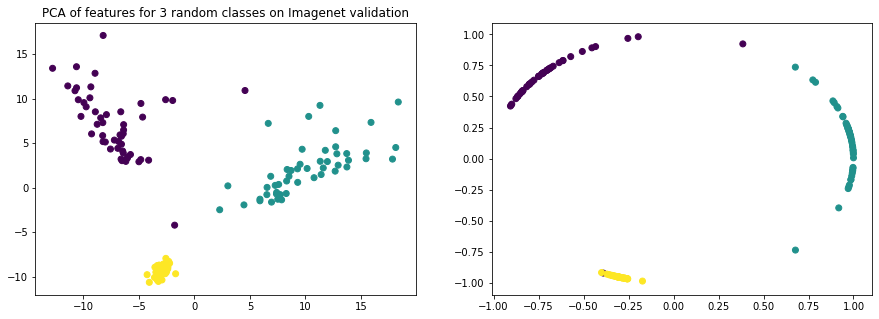

In [72]:
# best classes 364, 333, 986
# not so good 963, 749, 162
from sklearn.decomposition import PCA
o1 = all_output[all_target.eq(963)]
o2 = all_output[all_target.eq(749)]
o3 = all_output[all_target.eq(986)]
oo = torch.cat([o1, o2, o3], 0)

pca_features = PCA(n_components=2).fit_transform(oo)
pca_features_norm = torch.nn.functional.normalize(torch.from_numpy(pca_features))
c = [1,] * 50 + [2,] * 50 + [3,] * 50
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].scatter(pca_features[:, 0], pca_features[:, 1], c=c)
axes[1].scatter(pca_features_norm[:, 0], pca_features_norm[:, 1], c=c)
axes[0].set_title("PCA of features for 3 random classes on Imagenet validation")

array([[ 7.46849228e+00, -3.05177443e+00],
       [ 6.92851763e+00, -2.96389769e+00],
       [ 7.82671639e+00, -1.31563400e+00],
       [ 1.04704193e+01,  4.81692744e+00],
       [ 1.10584736e+01,  7.52003350e+00],
       [ 6.57051123e+00, -1.08018143e+01],
       [ 1.00237547e+01,  3.75395066e+00],
       [ 1.12574210e+01,  3.65190193e+00],
       [ 7.88388233e+00, -2.06737859e+00],
       [ 1.11550388e+01,  7.02196339e+00],
       [ 6.59792991e+00, -4.10734348e+00],
       [ 7.29219744e+00, -5.10455318e+00],
       [ 8.78821914e+00,  8.22988188e-02],
       [ 1.24467172e+01,  1.52503945e+00],
       [ 8.66876239e+00, -2.97684922e+00],
       [ 1.43735224e+01,  1.28035280e+01],
       [ 1.27261542e+01,  8.64873162e+00],
       [ 1.05715639e+01,  5.16966421e+00],
       [ 6.29349349e+00, -3.94712888e+00],
       [ 5.30766653e+00, -3.15453930e+00],
       [ 5.93232538e+00, -4.84796576e+00],
       [ 7.55631782e+00, -1.78924699e-01],
       [ 6.69977517e+00, -3.62988493e+00],
       [ 6.

# Some plots

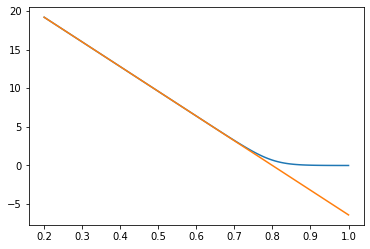

In [247]:
x = np.linspace(0.2, 1, num=100)
s = 32
d = 0.8
y = np.log(1 + np.e ** (s * d) / np.e ** (s * x))
plt.plot(x, y);
plt.plot(x, x * (-s) + s * d)

# Rectangle Loader

In [5]:
"""Eval model on ImageNet validation dataset"""
size=224
BS = 25 if size >= 384 else 125
val_loader = ValRectLoader(bs=BS, sz=size)
val_loader_i = iter(val_loader)
model = model.eval().cuda()

In [6]:
imgs, target = next(val_loader_i)
pred = model(imgs)# .cpu().detach()

In [29]:
pred /= pred.norm(dim=-1, keepdim=True)

In [18]:
pred.argmax(-1).eq(target).float().mean()

tensor(0.7520, device='cuda:0')

In [20]:
(pred / pred.norm(dim=-1, keepdim=True)).argmax(-1).eq(target).float().mean()

tensor(0.7520, device='cuda:0')

In [79]:
torch.nn.functional.normalize(torch.tensor([-1, -2, 3.0, 0.]), dim=0).softmax(-1)

tensor([0.1671, 0.1279, 0.4867, 0.2183])

In [75]:
tt = torch.tensor([-1, -2, 3.0, 0.])
tt /= tt.norm(2)
tt.softmax(-1)

tensor([0.1671, 0.1279, 0.4867, 0.2183])

In [32]:
ctmx_0 = pt.fit_wrapper.callbacks.Cutmix(0, 1000, prob=0)
ctmx = pt.fit_wrapper.callbacks.Cutmix(2, 1000, prob=1)
_, target_y = ctmx_0.cutmix(imgs, target) # turn to one-hot

In [36]:
target_y = target_y.clamp_min(1e-3)

# FixMatch Loader

In [2]:
size=224
BS = 25 if size >= 384 else 125
fixm_loader = DaliLoader(
    train=True,
    fixmatch=True,
    blur=True,
#     crop_method="full",
#     jitter=True,
#     resize_method="triang",
    random_interpolation=True
)
fixm_loader_i = iter(fixm_loader)

In [3]:
raw_images, labels = next(fixm_loader_i)
ctmx_0 = pt.fit_wrapper.callbacks.Cutmix(0, 1000, prob=0)
_, target_y = ctmx_0.cutmix(raw_images, labels) # turn to one-hot
# pred = model(raw_images).cpu()
images = (raw_images * 0.2 + 0.5).mul(255).clamp(0, 255).cpu().to(torch.uint8).transpose(1, 3).transpose(1, 2)

In [4]:
@interact(N=(0, 31))
def show(N=10):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(images[N])
    axes[1].imshow(images[N+32]) 

interactive(children=(IntSlider(value=10, description='N', max=31), Output()), _dom_classes=('widget-interact'…

In [259]:
correct = pred.argmax(-1)[32:].eq(labels.cpu())

In [260]:
top_pred = pred.sort(dim=1, descending=True)[0].softmax(-1)[:, :3].mul(100).round()
torch.cat([top_pred[:32], top_pred[32:]], dim=-1)

tensor([[84.,  0.,  0., 84.,  0.,  0.],
        [75.,  5.,  1., 91.,  1.,  0.],
        [98.,  0.,  0., 94.,  0.,  0.],
        [65., 15.,  5., 98.,  0.,  0.],
        [96.,  1.,  1., 94.,  0.,  0.],
        [39., 32., 10., 74., 15.,  1.],
        [95.,  0.,  0., 95.,  0.,  0.],
        [95.,  0.,  0., 93.,  0.,  0.],
        [73.,  3.,  1., 69.,  3.,  2.],
        [55., 17., 16., 83.,  1.,  1.],
        [90.,  1.,  0., 91.,  2.,  0.],
        [88.,  1.,  1., 90.,  0.,  0.],
        [45., 38.,  0., 43., 33.,  0.],
        [90.,  0.,  0., 89.,  0.,  0.],
        [79.,  1.,  1., 83.,  1.,  1.],
        [54., 15.,  7., 92.,  0.,  0.],
        [66., 13.,  2., 66., 12.,  2.],
        [93.,  0.,  0., 90.,  0.,  0.],
        [84.,  1.,  1., 86.,  1.,  1.],
        [81.,  0.,  0., 83.,  0.,  0.],
        [83.,  3.,  1., 87.,  3.,  1.],
        [66., 13.,  3., 75.,  8.,  1.],
        [48.,  4.,  4., 86.,  0.,  0.],
        [47., 12., 10., 93.,  1.,  0.],
        [ 7.,  5.,  3., 56., 26.,  1.],


In [262]:
top_pred[:32][correct]

tensor([[84.,  0.,  0.],
        [75.,  5.,  1.],
        [98.,  0.,  0.],
        [65., 15.,  5.],
        [96.,  1.,  1.],
        [95.,  0.,  0.],
        [95.,  0.,  0.],
        [73.,  3.,  1.],
        [55., 17., 16.],
        [90.,  1.,  0.],
        [88.,  1.,  1.],
        [45., 38.,  0.],
        [90.,  0.,  0.],
        [79.,  1.,  1.],
        [54., 15.,  7.],
        [66., 13.,  2.],
        [93.,  0.,  0.],
        [84.,  1.,  1.],
        [81.,  0.,  0.],
        [83.,  3.,  1.],
        [66., 13.,  3.],
        [48.,  4.,  4.],
        [47., 12., 10.],
        [ 7.,  5.,  3.],
        [71.,  8.,  6.],
        [95.,  3.,  0.],
        [84.,  1.,  1.],
        [72., 11.,  0.],
        [99.,  0.,  0.],
        [89.,  0.,  0.],
        [91.,  0.,  0.]])

In [220]:
(pred.softmax(-1) > 0.1).sum()

tensor(79)

In [168]:
nn = torch.nn
class FixMatchLoss(nn.Module):
    def __init__(self, hard_weight=0.01, hard_pct=0.01):
        super().__init__()
        self.criterion = pt.losses.BinaryKLDivLoss(reduction="none").cuda()
        self.hard_criterion = pt.losses.CrossEntropyLoss(mode="binary", reduction="none").cuda()
        self.hard_weight = hard_weight
        self.hard_pct = hard_pct

    def forward(self, y_pred, y_true):
        half_bs = y_pred.size(0) // 2
        if y_true.dim() == 1:
            y_true_one_hot = torch.zeros_like(y_pred)
            y_true_one_hot.scatter_(1, y_true.unsqueeze(1), 1.0)
        raw_soft_loss = self.criterion(y_pred[:half_bs], y_pred[half_bs:].detach().sigmoid())
        raw_hard_loss = self.hard_criterion(y_pred[:half_bs], y_true_one_hot[half_bs:])
        topk_n = int(self.hard_pct * y_pred.size(1))
        # take TOPK to avoid pushing close to 0 predictions even further
        soft_loss = raw_soft_loss.topk(topk_n, sorted=False)[0].mean()
        hard_loss = raw_hard_loss.topk(topk_n, sorted=False)[0].mean()
        print(f"Hard: {hard_loss.item()}. Soft: {soft_loss.item()}\n")
        return soft_loss + self.hard_weight * hard_loss


In [169]:
ll = pt.losses.BinaryKLDivLoss(reduction="none").cuda()
l = ll(pred[:32], pred[32:])

In [170]:
pred[0, :3], pred[32, :3]

(tensor([-22.0528,   7.6007,   1.4845]),
 tensor([-23.5247,   8.5394,   3.6182]))

In [178]:
ll(pred[:32], pred[32:].sigmoid()).topk(20, dim=1)[0].sum()

tensor(486.5403)

In [179]:
(pred.sigmoid() > 0.01).sum()

tensor(34483)

In [188]:
FixMatchLoss()(pred.cuda(), labels)

Hard: 94.30317687988281. Soft: 1.0787804126739502



tensor(2.0218, device='cuda:0')